# HEADSS2 Demo
This notebook goes through the key functionality of HEADSS2. For a more detailed background as well as the API reference, see the official [documentation](https://headss2.readthedocs.io/en/latest/).

## Spark setup
HEADSS2 0.2.0 onwards relies on Spark for processing.

If you do not have a SparkSession available in your environment already, you can create one:

In [23]:
from pyspark.sql import SparkSession


spark = (
    SparkSession.builder
        .appName("test-regions")
        .config("spark.driver.memory", "16g")  
        .config("spark.executor.memory", "8g")
        .config("spark.executor.cores", "4")
        .getOrCreate()
)


## Example datasets
HEADSS2 comes with ten example datasets


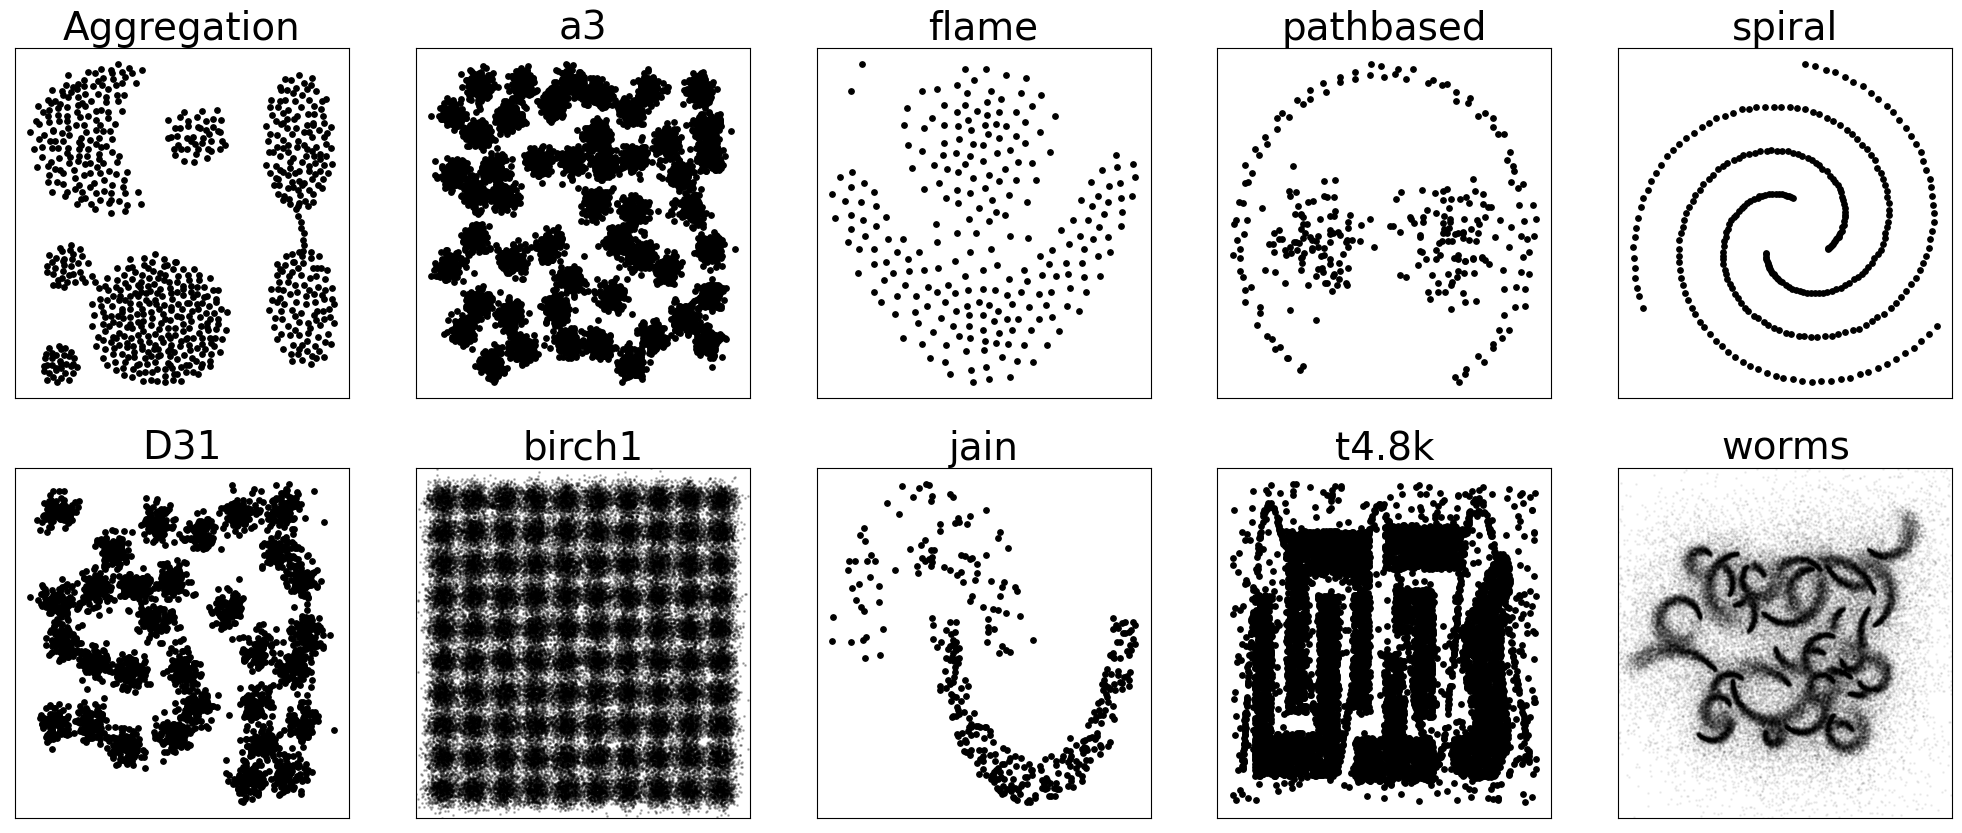

In [2]:
import base64
from IPython.display import HTML

with open("datasets.png", "rb") as image_file:
    encoded = base64.b64encode(image_file.read()).decode('utf-8')

HTML(f'<img src="data:image/png;base64,{encoded}" />')


The `dataset(name)` function retrieves each dataset as a Pandas dataframe. 

In [3]:
from headss2 import dataset
dataset("D31")

,x,y
0,25.0514,5.7475
1,26.6614,7.3414
2,25.2653,6.2466
3,25.2285,4.7447
4,25.7529,5.1564
...,...,...
3095,5.1380,16.6150
3096,5.7360,16.9991
3097,5.2760,17.2475
3098,6.4444,16.2033


Note the use of an underscore instead of a full stop in the name of `t4_8k`

In [4]:
t4_8k = dataset("t4_8k")
t4_8k

,x,y
0,68.601997,102.491997
1,454.665985,264.808990
2,101.283997,169.285995
3,372.614990,263.140991
4,300.989014,46.555000
...,...,...
7995,442.420990,303.721985
7996,495.451996,288.502991
7997,267.605011,141.725006
7998,238.358002,252.729996


## Simplified API
HEADSS2 0.2.0 comes with an optional simplified API to make regions, cluster data, stitch regions, and merge clusters in fewer lines of code. This is more similar to the original HEADSS implementation. The option to call individual modules remains and is illustrated below.

#### Key parameters

**Splitting/stitching parameters**
* `n` - how many splits per dimension. More splits could mean faster processing, but introduces overhead by increasing the amount of stitching required.

**Clustering parameters (passed to HBSCAN)**
<br>
See the [HDBSCAN docs](https://hdbscan.readthedocs.io/en/latest/index.html) for more details
* `min_cluster_size` - smallest acceptable cluster size
* `min_samples` - relates to conservativeness of clustering (see docs)
* `allow_single_cluster` - allow HDBSCAN to return single cluster?
* `clustering_method` - HDBSCAN clustering method - choose from 'leaf' or 'eom'

**Post-clustering filtering**
* `drop_unclustered` - whether to drip

**Merging thresholds** </br>
The difference between the two first thresholds is slightly convoluted. They both consider the fraction of points that are jointly within both compared clusters, but the `bound_region_point_overlap_threshold` only considers this in relation to the bound overlap region between the two clusters.
* `total_point_overlap_threshold` - minimum fraction of joint points of the smaller cluster
* `bound_region_point_overlap_threshold` - minimum fraction of bound overlap region that is joint points between both clusters
* `min_n_overlap` - minimum number of shared points to allow merging


In [ ]:
from headss2 import HEADSS2

In [6]:
headss_obj = HEADSS2(
    n = 2,
    min_cluster_size=10,
    min_samples=10,
    allow_single_cluster=False,
    clustering_method="eom",
    drop_unclustered=True,
    total_point_overlap_threshold=0.1,
    bound_region_point_overlap_threshold=0.5,
    min_n_overlap=10,
    spark_session=spark
)

headss_obj.fit(t4_8k, ["x", "y"])

DataFrame[x: float, y: float, region: int, cluster: string]

In [7]:
headss_obj.merged.show()

+-------+-------+------+-------+
|      x|      y|region|cluster|
+-------+-------+------+-------+
| 68.602|102.492|     0|    0_3|
|110.171| 55.648|     0|    0_3|
|118.856| 47.446|     0|    0_3|
|204.207| 133.41|     0|    0_3|
|  78.26|139.327|     0|    0_3|
| 68.434| 59.125|     0|    0_3|
| 84.023| 90.084|     0|    0_3|
|214.477| 63.822|     0|    0_3|
|163.141| 66.302|     0|    0_3|
| 63.076|  78.06|     0|    0_3|
| 77.562|152.847|     0|    0_3|
| 79.098|128.405|     0|    0_3|
| 76.775| 83.792|     0|    0_3|
| 88.132| 84.512|     0|    0_3|
|201.808| 97.972|     0|    0_3|
|209.493| 54.874|     0|    0_3|
|199.571|159.617|     0|    0_3|
| 74.259|114.187|     0|    0_3|
|118.652| 47.566|     0|    0_3|
|206.664| 148.38|     0|    0_3|
+-------+-------+------+-------+
only showing top 20 rows


# Using individual modules
## Making regions

In [8]:
a3 = dataset("a3")

In [9]:
from headss2 import make_regions

In [ ]:
regs_a3 = make_regions(df = a3, 
             n = 2,
             cluster_columns = ['x', 'y'],
             spark_session=spark)

`make_regions` returns a `Regions` object, with two attributes: `split_data` (dataset partitioned into regions) and `split_regions` (summary statistics about each region)

In [24]:
regs_a3.split_data.show()

+-----+-----+------+
|    x|    y|region|
+-----+-----+------+
|49126|46607|     4|
|48995|47894|     4|
|49049|47984|     4|
|48535|46223|     4|
|48525|47944|     4|
|48350|47100|     4|
|49126|46607|     5|
|48995|47894|     5|
|49049|47984|     5|
|48535|46223|     5|
|48536|49021|     5|
|48525|47944|     5|
|48837|48575|     5|
|48350|47100|     5|
|48039|50185|     5|
|48904|50964|     5|
|53920|42968|     7|
|52019|42206|     7|
|52570|42476|     7|
|54220|42081|     7|
+-----+-----+------+
only showing top 20 rows


In [12]:
regs_a3.split_regions

,region,x_min,x_max,y_min,y_max
0,0,0.00,32767.50,976.0,32559.0
1,1,0.00,32767.50,16767.5,48350.5
2,2,0.00,32767.50,32559.0,64142.0
3,3,16383.75,49151.25,976.0,32559.0
4,4,16383.75,49151.25,16767.5,48350.5
5,5,16383.75,49151.25,32559.0,64142.0
6,6,32767.50,65535.00,976.0,32559.0
7,7,32767.50,65535.00,16767.5,48350.5
8,8,32767.50,65535.00,32559.0,64142.0


## Clustering with HDBSCAN

This module is just a wrapper around HDBSCAN, so to select appropriate parameters for your dataset, please refer to the [HDBSCAN documentation](https://hdbscan.readthedocs.io/en/latest/index.html).

In [13]:
from headss2 import cluster
clustered_a3 = cluster(split_data=regs_a3.split_data,
        min_cluster_size=10,
        min_samples=None,
        clustering_method='eom',
        allow_single_cluster=False,
        cluster_columns=['x', 'y'])

In [14]:
clustered_a3.show()

+-------+-------+------+-------+
|      x|      y|region|cluster|
+-------+-------+------+-------+
| 8960.0|29349.0|     0|    0_1|
| 9566.0|30666.0|     0|    0_1|
|10002.0|29085.0|     0|    0_1|
| 9051.0|28004.0|     0|    0_1|
| 8262.0|29745.0|     0|    0_1|
| 9612.0|30786.0|     0|    0_1|
| 8479.0|29223.0|     0|    0_1|
| 9685.0|31428.0|     0|    0_1|
|10844.0|29711.0|     0|    0_1|
|10599.0|28555.0|     0|    0_1|
| 9774.0|29756.0|     0|    0_1|
| 8628.0|26811.0|     0|    0_1|
|10022.0|30615.0|     0|    0_1|
| 9438.0|29445.0|     0|    0_1|
|12814.0|27360.0|     0|    0_1|
| 9850.0|30329.0|     0|    0_1|
|10836.0|28222.0|     0|    0_1|
|10426.0|29327.0|     0|    0_1|
|10304.0|29461.0|     0|    0_1|
| 8230.0|28746.0|     0|    0_1|
+-------+-------+------+-------+
only showing top 20 rows


## Stitching
Stitching refers to the process of joining the regions that have each been processed in parallel. There are no parameters for users to fine tune at this stage

In [18]:
from headss2 import stitch
stitch(clustered=clustered_a3,
       cluster_columns=['x', 'y'],
       stitch_regions=regs_a3.stitch_regions).show()

+------+-------+------+-------+
|     x|      y|region|cluster|
+------+-------+------+-------+
|4764.0|24290.0|     0|    0_2|
|3241.0|23730.0|     0|    0_2|
|3373.0|24827.0|     0|    0_2|
| 894.0|24681.0|     0|    0_2|
|5567.0|22531.0|     0|    0_2|
|3190.0|24760.0|     0|    0_2|
|3603.0|25332.0|     0|    0_2|
|3771.0|25719.0|     0|    0_2|
|3246.0|21924.0|     0|    0_2|
|3589.0|21932.0|     0|    0_2|
|2371.0|24287.0|     0|    0_2|
|2269.0|24231.0|     0|    0_2|
|3097.0|21394.0|     0|    0_2|
|4978.0|22611.0|     0|    0_2|
|4753.0|24184.0|     0|    0_2|
|2347.0|25347.0|     0|    0_2|
|5413.0|26551.0|     0|    0_2|
|2296.0|25155.0|     0|    0_2|
|1452.0|22110.0|     0|    0_2|
|4978.0|22896.0|     0|    0_2|
+------+-------+------+-------+
only showing top 20 rows


## Merging

Finally, HEADSS2 can identify overlapping clusters and merge them to improve results.

`a3` does not require merging, so we are going to use `t4_8k` for this.

First, we'll need to make regions, cluster, and stitch the data as before:

In [16]:
t4_8k = dataset("t4_8k")

regs_t4_8k = make_regions(df=t4_8k, n=2, cluster_columns=['x', 'y'], spark_session=spark)

clustered_t4_8k = cluster(split_data=regs_t4_8k.split_data,
                          cluster_columns=['x', 'y'],
                          min_cluster_size=30,
                          min_samples=10,
                          clustering_method='eom',
                          allow_single_cluster=False)

stitched_t4_8k = stitch(clustered=clustered_t4_8k,
                        cluster_columns=['x', 'y'],
                        stitch_regions=regs_t4_8k.stitch_regions)

Then perform the merging. See the [documentation](https://headss2.readthedocs.io/en/latest/) for details on these parameters.

In [20]:
from headss2 import cluster_merge

merged_t4_8k = cluster_merge(
    clustered=stitched_t4_8k,
    split_regions=regs_t4_8k.split_regions,
    cluster_columns=["x", "y"],
    min_n_overlap=10,
    bound_region_point_overlap_threshold = 0.1, 
    total_point_overlap_threshold = 0.5)

#### Before merging:

<Axes: xlabel='x', ylabel='y'>

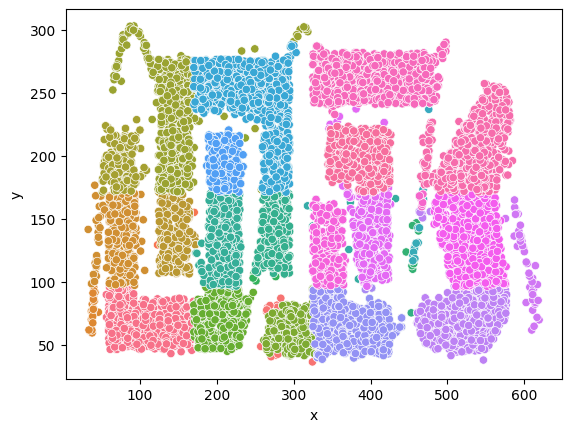

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
clustered_pd = clustered_t4_8k.toPandas()
sns.scatterplot(x=clustered_pd.x, y=clustered_pd.y, hue= clustered_pd.cluster, legend=None)

#### With merging:

<Axes: xlabel='x', ylabel='y'>

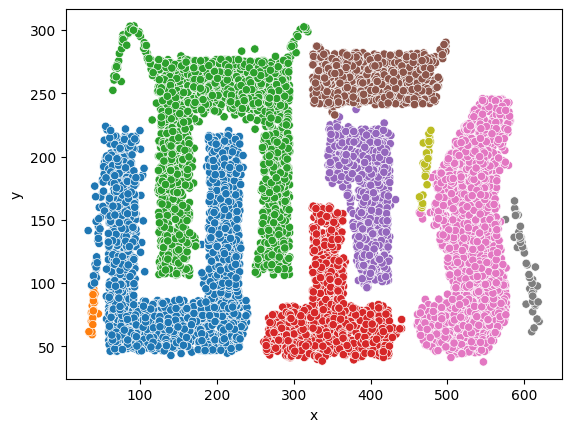

In [22]:
pd_merged = merged_t4_8k.toPandas()
sns.scatterplot(x=pd_merged.x, y=pd_merged.y, hue= pd_merged.cluster, legend=None)

Here, slightly more aggressive merging may be required. Threshold parameters are best found by trial and error.